<h1>Applied Data Science Capstone<h1>

_This notebook will be used mainly for the applied data science capstone project thats part of the <b>IBM Data Science Professional Certificate</b> course._





<h2>1. Introduction</h2>

This project is about helping several stakeholders decide where it is the most optimal place to open a 24 hours highly sophisticated gym in Toronto. Given that Toronto is the most populous city in Canada and one of the highest ranked cities in the world on health and high quality of living, opening a gym there is an easy decision for an investment group. With that said we first need to explore the current gym market in the city and decide where it will be the smartest location to open a gym to maximize the profits.

The investors are interested in neighborhoods that meet the following criteria:

- The neighborhood should have average or above average population
- Since it is a 24 hours gym a higher percentage of people younger than 45 is preferred
- Since it is a highly sophisticated gym, the membership will be higher so the household incomes in that area should be average or above average.

With the data gathered by the explorations for this criteria, the goal is to find and recommend the optimal areas to the investors to open their gym. They will use this data to find places to buy or rent for their business. 

Also this information can be shared with other investors that are looking to open a new gym or a recreational center.

<h2>2. Data</h2>

<h3>2.1 Data Description</h3>

The data for the needs of this project will come from the following sources:
- City of Toronto Neighborhoods:
https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050
- City of Toronto Neighborhoods demographics data:
https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods
- Foursquare API to collect information on other gyms and competitors in Toronto

<h3>2.2 Data Preparation</h3>

First let's import the libraries that will be used

In [1]:

import pandas as pd
import numpy as np
import lxml

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!pip install requests
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.spatial.distance import cdist



Now let's load the coordinates of the city's boroughs into a pandas dataframe

In [2]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050"
data = pd.read_html(url, header=0)
df = data[0]

#rename the columns
df.rename(columns={'Postcode':'PostalCode','Neighbourhood':'Neighborhood'},inplace=True)

#delete the rows with unassigned Borough
df=df[df['Borough']!='Not assigned']
df=df[df['Neighborhood']!='Not assigned']

#df=df.groupby(['PostalCode', 'Borough']).agg({'Neighborhood' : ','.join})

#We can see that Neighborhood has become the index of the dataframe, so we need to reset it for the next operations
df.reset_index(inplace=True)

#Next we replace the neighborhoods with unassigned values with the name of the borough as per assignment
#df['Neighborhood'][df['Neighborhood']=='Not assigned']=df['Borough'][df['Neighborhood']=='Not assigned']

coords = pd.read_csv('https://cocl.us/Geospatial_data')

coords.rename(columns={'Postal Code':'PostalCode'},inplace=True)

df1 = pd.merge(df, coords, left_on=  ['PostalCode'],
            right_on= ['PostalCode'], 
            how = 'left')
            
df1.head()

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,2,M3A,North York,Parkwoods,43.753259,-79.329656
1,3,M4A,North York,Victoria Village,43.725882,-79.315572
2,4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,5,M6A,North York,Lawrence Heights,43.718518,-79.464763
4,6,M6A,North York,Lawrence Manor,43.718518,-79.464763


Now let's load the demographics for the city.
We will only need the Name of the neighborhood, Population, Population Density and the Average Income data columns.

In [3]:
url = "https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods"
data = pd.read_html(url, header=0)
df_n = data[1][['Name','Population','Density (people/km2)','Average Income']]
df_n.head(10)

,Name,Population,Density (people/km2),Average Income
0,Toronto CMA Average,5113149,866,40704
1,Agincourt,44577,3580,25750
2,Alderwood,11656,2360,35239
3,Alexandra Park,4355,13609,19687
4,Allenby,2513,4333,245592
5,Amesbury,17318,4934,27546
6,Armour Heights,4384,1914,116651
7,Banbury,6641,2442,92319
8,Bathurst Manor,14945,3187,34169
9,Bay Street Corridor,4787,43518,40598


Now let's merge the location dataframe with the demographics dataframe

In [4]:
#merge the dataframes
df_f=pd.merge(df1, df_n, left_on=  ['Neighborhood'],
            right_on= ['Name'], 
            how = 'left')
df_f.head()       

,index,PostalCode,Borough,Neighborhood,Latitude,Longitude,Name,Population,Density (people/km2),Average Income
0,2,M3A,North York,Parkwoods,43.753259,-79.329656,Parkwoods,26533.0,5349.0,34811.0
1,3,M4A,North York,Victoria Village,43.725882,-79.315572,Victoria Village,17047.0,3612.0,29657.0
2,4,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,NaN,NaN,NaN,NaN
3,5,M6A,North York,Lawrence Heights,43.718518,-79.464763,Lawrence Heights,3769.0,1178.0,29867.0
4,6,M6A,North York,Lawrence Manor,43.718518,-79.464763,Lawrence Manor,13750.0,6425.0,36361.0


Now let's clean up the data. Delete unnecessary columns and rename some columns.

In [5]:
#delete unnecessary columns
df_f.drop(['Name','PostalCode'],axis=1,inplace=True)

#rename 
df_f.rename(columns={'Density (people/km2)':'Population Density'},inplace=True)
df_f.head()

,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income
0,2,North York,Parkwoods,43.753259,-79.329656,26533.0,5349.0,34811.0
1,3,North York,Victoria Village,43.725882,-79.315572,17047.0,3612.0,29657.0
2,4,Downtown Toronto,Harbourfront,43.654260,-79.360636,NaN,NaN,NaN
3,5,North York,Lawrence Heights,43.718518,-79.464763,3769.0,1178.0,29867.0
4,6,North York,Lawrence Manor,43.718518,-79.464763,13750.0,6425.0,36361.0


Now let's get the coordinates of Toronto

In [6]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode('Toronto, Canada')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Set up the Foursquare API

In [7]:
CLIENT_ID = 'A5S2CJNU43XNBJEADGVEDLOR024ZP5BC5KZY2E1F0WT0DZEI' # your Foursquare ID
CLIENT_SECRET = 'GIPWZSDNB1GYTVSRWTFV2E2JZBHBDYCORNL3MVRVDUOWQADI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A5S2CJNU43XNBJEADGVEDLOR024ZP5BC5KZY2E1F0WT0DZEI
CLIENT_SECRET:GIPWZSDNB1GYTVSRWTFV2E2JZBHBDYCORNL3MVRVDUOWQADI


Method to get all the nearby venues

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's get all nearby venues for each neighborhood

In [9]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=df_f['Neighborhood'],
                                   latitudes=df_f['Latitude'],
                                   longitudes=df_f['Longitude']
                                  )

Parkwoods
Victoria Village
Harbourfront
Lawrence Heights
Lawrence Manor
Queen's Park
Islington Avenue
Rouge
Malvern
Don Mills North
Woodbine Gardens
Parkview Hill
Ryerson
Garden District
Glencairn
Cloverdale
Islington
Martin Grove
Princess Gardens
West Deane Park
Highland Creek
Rouge Hill
Port Union
Flemingdon Park
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Bloordale Gardens
Eringate
Markland Wood
Old Burnhamthorpe
Guildwood
Morningside
West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor
Downsview North
Wilson Heights
Thorncliffe Park
Adelaide
King
Richmond
Dovercourt Village
Dufferin
Scarborough Village
Fairview
Henry Farm
Oriole
Northwood Park
York University
East Toronto
Harbourfront East
Toronto Islands
Union Station
Little Portugal
Trinity
East Birchmount Park
Ionview
Kennedy Park
Bayview Village
CFB Toronto
Downsview East
The Danforth West
Riverdale
Design Exchange
Toro

Let's examine the shape of the venues dataframe 

In [10]:
print(toronto_venues.shape)
toronto_venues.head()

(4366, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [11]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,100,100,100,100,100,100
Agincourt,5,5,5,5,5,5
Agincourt North,2,2,2,2,2,2
Albion Gardens,9,9,9,9,9,9
Alderwood,11,11,11,11,11,11
...,...,...,...,...,...,...
Woodbine Heights,9,9,9,9,9,9
York Mills,1,1,1,1,1,1
York Mills West,4,4,4,4,4,4


Now let's see how many venues are there that have the word Gym or Fitness in their name. We will assume these objects are the competition in the city.

In [12]:
toronto_venues[(toronto_venues['Venue Category'].str.contains('Gym', regex=False)) |
                 (toronto_venues['Venue Category'].str.contains('Fitness', regex=False)) ].count()

Neighborhood              85
Neighborhood Latitude     85
Neighborhood Longitude    85
Venue                     85
Venue Latitude            85
Venue Longitude           85
Venue Category            85
dtype: int64

Now let's make a dataframe that holds count of gyms in each neighborhood 

In [13]:
toronto_gyms = toronto_venues[(toronto_venues['Venue Category'].str.contains('Gym', regex=False)) |
                 (toronto_venues['Venue Category'].str.contains('Fitness', regex=False))].groupby(['Neighborhood']).count()
toronto_gyms.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Longitude', 'Venue', 'Venue Latitude'], axis = 1, inplace = True)
toronto_gyms.rename(columns = {'Venue Category':'Number of Gyms'}, inplace=True)
toronto_gyms.head()

,Number of Gyms
Neighborhood,
Adelaide,3
Alderwood,1
Brockton,2
Canada Post Gateway Processing Centre,1
Central Bay Street,2


Now let's join the gyms data to the demographics dataframe

In [14]:
df_f = df_f.join(toronto_gyms, on='Neighborhood')
df_f.head()

,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
0,2,North York,Parkwoods,43.753259,-79.329656,26533.0,5349.0,34811.0,NaN
1,3,North York,Victoria Village,43.725882,-79.315572,17047.0,3612.0,29657.0,NaN
2,4,Downtown Toronto,Harbourfront,43.654260,-79.360636,NaN,NaN,NaN,NaN
3,5,North York,Lawrence Heights,43.718518,-79.464763,3769.0,1178.0,29867.0,NaN
4,6,North York,Lawrence Manor,43.718518,-79.464763,13750.0,6425.0,36361.0,NaN


In [15]:
df_f.head()

,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
0,2,North York,Parkwoods,43.753259,-79.329656,26533.0,5349.0,34811.0,NaN
1,3,North York,Victoria Village,43.725882,-79.315572,17047.0,3612.0,29657.0,NaN
2,4,Downtown Toronto,Harbourfront,43.654260,-79.360636,NaN,NaN,NaN,NaN
3,5,North York,Lawrence Heights,43.718518,-79.464763,3769.0,1178.0,29867.0,NaN
4,6,North York,Lawrence Manor,43.718518,-79.464763,13750.0,6425.0,36361.0,NaN


Fill NaN values with 0 and remove rows that do not have Population data.

In [44]:
df_f = df_f.fillna(0)
df_f = df_f[df_f['Population']!=0]

Examine the final data

In [45]:
df_f.head(20)

,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
0,2,North York,Parkwoods,43.753259,-79.329656,26533.0,5349.0,34811.0,0.0
1,3,North York,Victoria Village,43.725882,-79.315572,17047.0,3612.0,29657.0,0.0
3,5,North York,Lawrence Heights,43.718518,-79.464763,3769.0,1178.0,29867.0,0.0
4,6,North York,Lawrence Manor,43.718518,-79.464763,13750.0,6425.0,36361.0,0.0
7,10,Scarborough,Rouge,43.806686,-79.194353,22724.0,791.0,29230.0,0.0
8,11,Scarborough,Malvern,43.806686,-79.194353,44324.0,5003.0,25677.0,0.0
13,17,Downtown Toronto,Garden District,43.657162,-79.378937,8240.0,15846.0,37614.0,2.0
18,24,Etobicoke,Princess Gardens,43.650943,-79.554724,9288.0,2249.0,80607.0,0.0
19,25,Etobicoke,West Deane Park,43.650943,-79.554724,4395.0,2063.0,41582.0,0.0
20,26,Scarborough,Highland Creek,43.784535,-79.160497,12853.0,2505.0,33640.0,0.0


With this we are done with the data preparation process

<h1>3. Methodology and Analysis </h1>

After cleaning and preparing the data we will firstly apply some basic visually exploatory techniques to the data. Then replace some of the data with normalised data. And in the end perform cluster analysis of the data to find the best cluster of neighbornoods to open our gym.

<h2> Exploring the Data </h2>

In [46]:
df_f.describe()

,index,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,122.562500,43.706390,-79.386194,15103.375000,6679.112500,47151.425000,0.262500
std,76.805004,0.054419,0.115452,9958.204189,9902.481244,36281.688042,0.568002
min,2.000000,43.602414,-79.588437,627.000000,198.000000,21155.000000,0.000000
25%,50.500000,43.656285,-79.478122,9031.000000,2964.750000,27399.500000,0.000000
50%,124.000000,43.706122,-79.388790,12939.000000,4061.500000,34997.000000,0.000000
75%,179.750000,43.753526,-79.295145,17573.500000,6601.500000,48329.000000,0.000000
max,272.000000,43.815252,-79.160497,48507.000000,63765.000000,214110.000000,2.000000


Let's create a map with circle markers for each neighborhood

In [47]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df_f['Latitude'], df_f['Longitude'], df_f['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#0055ff',
        fill_opacity=0.75,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now let's use barcharts to explore the data in the dataframe

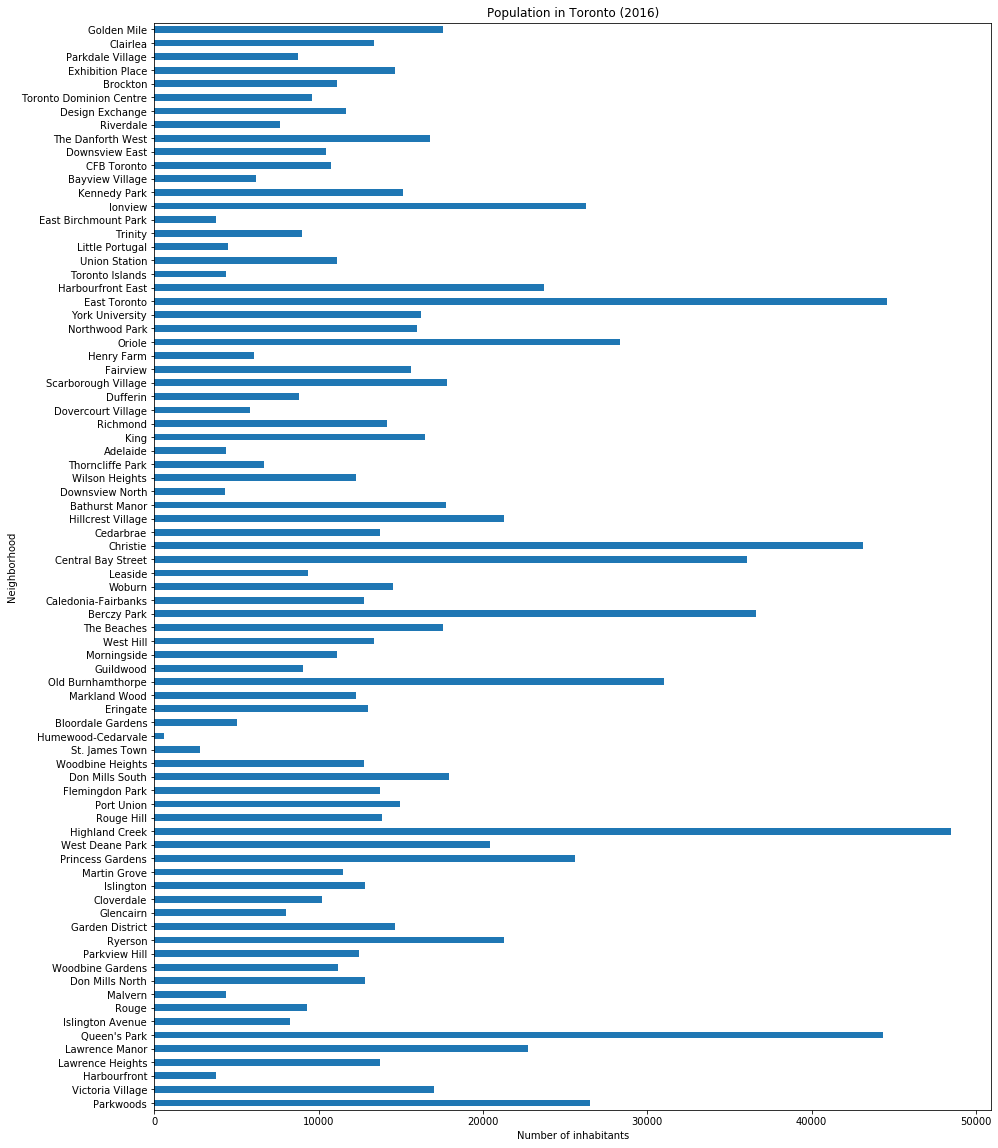

In [49]:
import matplotlib.pyplot as plt
# step 2: plot data
df_f[['Neighborhood', 'Population']].plot(kind='barh', figsize=(15, 20), legend = None)

plt.title('Population in Toronto (2016)') # add title to the plot
plt.xlabel('Number of inhabitants') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.yticks (np.arange(80), df['Neighborhood'])
plt.show()

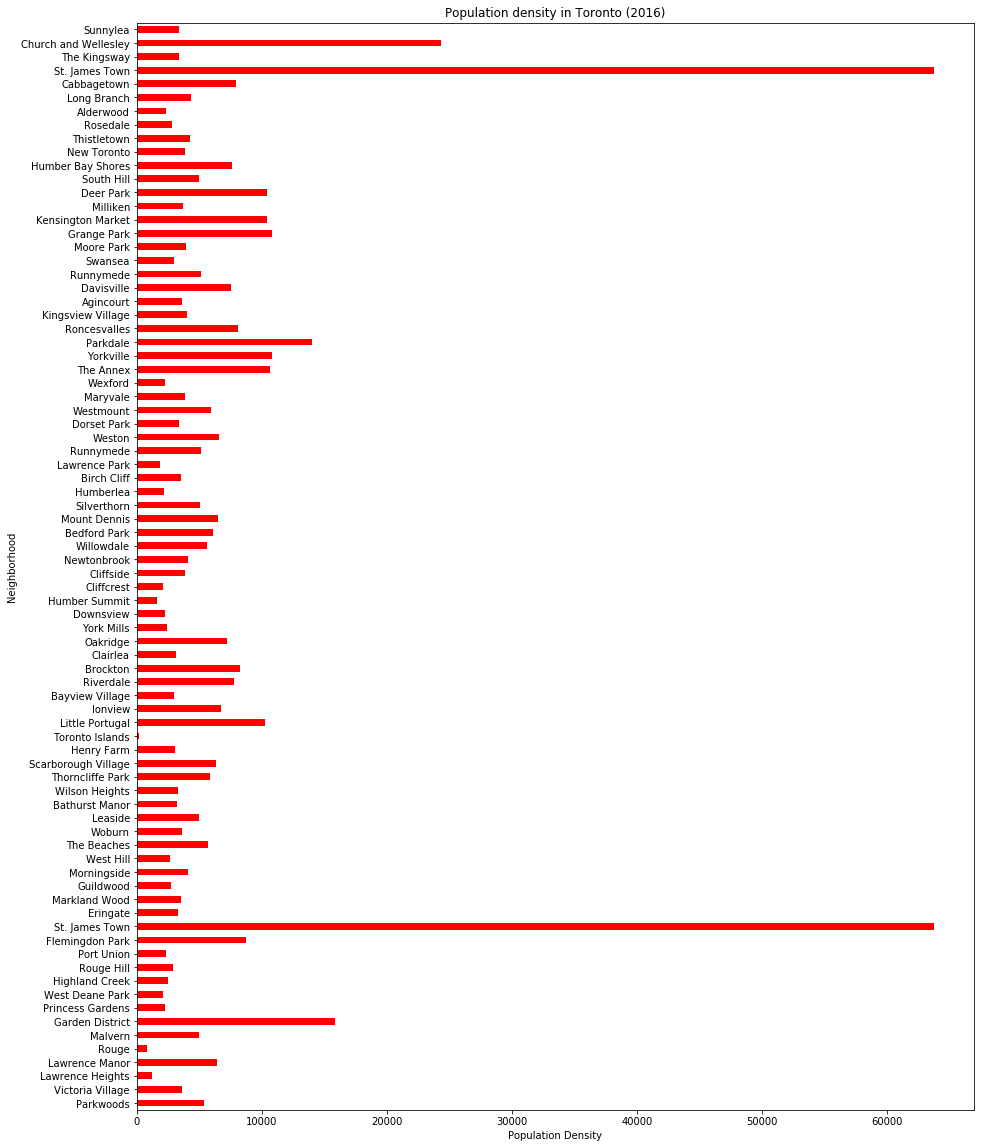

In [53]:
df_f[['Neighborhood', 'Population Density']].plot(kind='barh', figsize=(15, 20), legend = None, color='red')

plt.title('Population density in Toronto (2016)') # add title to the plot
plt.xlabel('Population Density') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.yticks (np.arange(80), df_f['Neighborhood'])
plt.show()

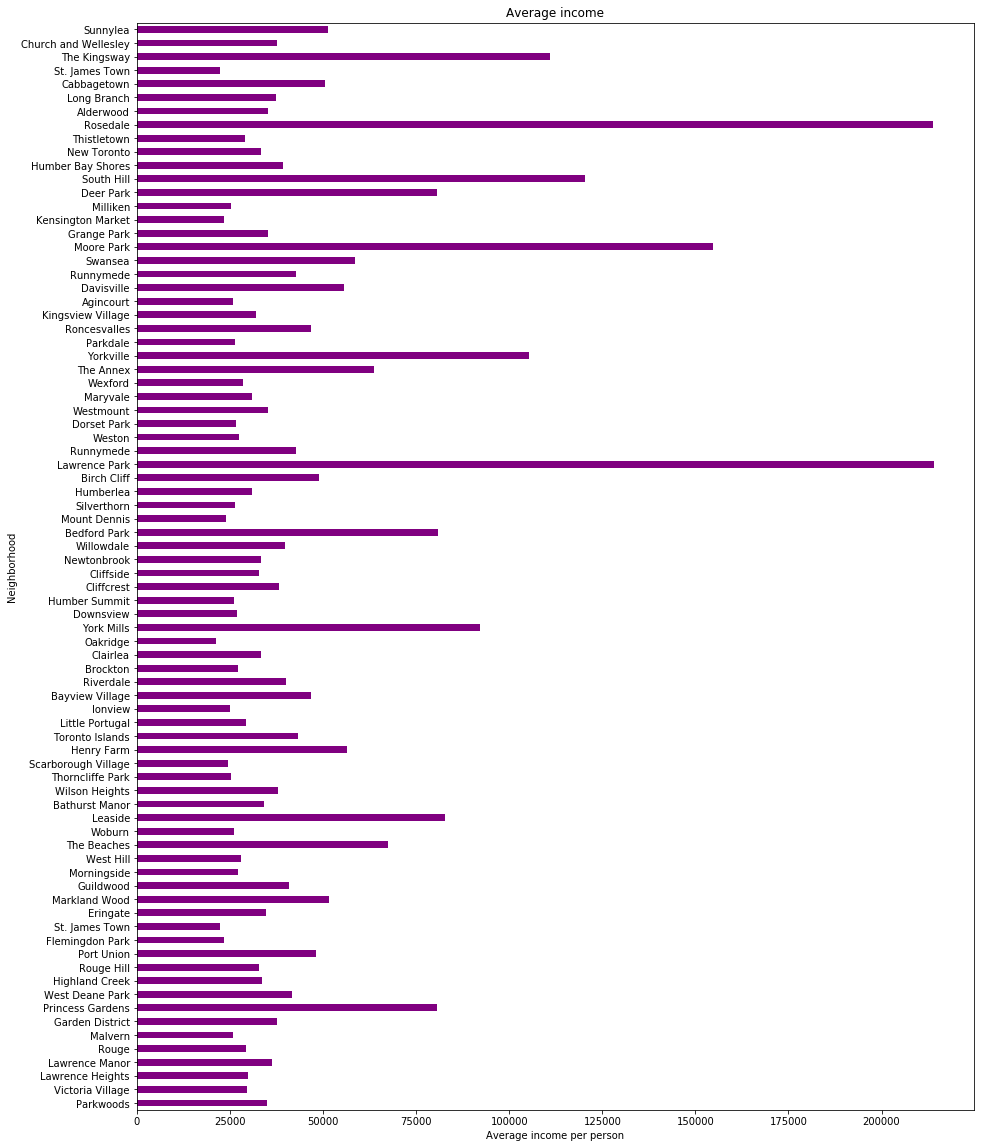

In [115]:
df_f[['Neighborhood', 'Average Income']].plot(kind='barh', figsize=(15, 20), legend = None, color = 'purple')

plt.title('Average income') # add title to the plot
plt.xlabel('Average income per person') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.yticks (np.arange(80), df_f['Neighborhood'])
plt.show()

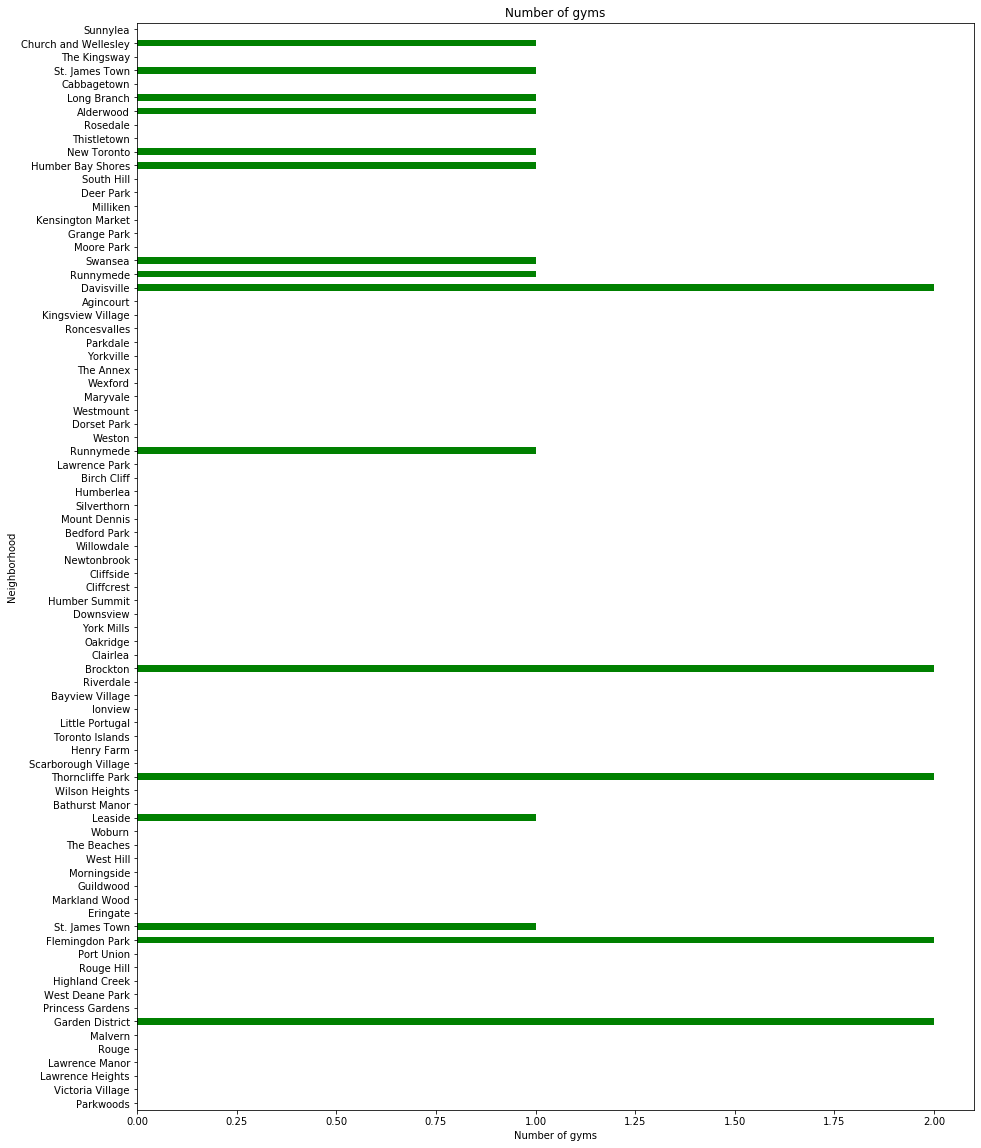

In [116]:
df_f[['Neighborhood', 'Number of Gyms']].plot(kind='barh', figsize=(15, 20), legend = None, color = 'green')

plt.title('Number of gyms') # add title to the plot
plt.xlabel('Number of gyms') # add to x-label to the plot
plt.ylabel('Neighborhood') # add y-label to the plot
plt.yticks (np.arange(80), df_f['Neighborhood'])
plt.show()

<h2>3.2 Cluster Analysis</h2>

Now we will reduce the data of the unnecesasry columns and combine the number of gyms with the population in each neighborhood in one column in order to apply the K-means algorithm which will help us identify the number of clusters.

In [84]:
 df_cl = df_f.drop(['Borough','Latitude', 'Longitude', 'Population Density','Neighborhood'],axis = 1)
 df_cl['Number of gyms per 1000 people']= df_cl['Number of Gyms']/(df_cl['Population']/1000)
 df_cl.drop(['Population','Number of Gyms'],axis=1,inplace=True)
 df_cl.reset_index() 
 df_cl=df_cl.drop(['index'],axis=1)
 df_cl.head(10)

,Average Income,Number of gyms per 1000 people
0,34811.0,0.000000
1,29657.0,0.000000
3,29867.0,0.000000
4,36361.0,0.000000
7,29230.0,0.000000
8,25677.0,0.000000
13,37614.0,0.242718
18,80607.0,0.000000
19,41582.0,0.000000
20,33640.0,0.000000


Now we apply normalization

In [85]:
df_cl=StandardScaler().fit_transform(df_cl.values)
df_cl

array([[-0.34227413, -0.43305491],
       [-0.48522552, -0.43305491],
       [-0.47940096, -0.43305491],
       [-0.29928332, -0.43305491],
       [-0.4970688 , -0.43305491],
       [-0.59561484, -0.43305491],
       [-0.2645301 ,  3.85472668],
       [ 0.92792412, -0.43305491],
       [-0.15447362, -0.43305491],
       [-0.374753  , -0.43305491],
       [-0.39644256, -0.43305491],
       [ 0.0267812 , -0.43305491],
       [-0.65680047,  1.22670552],
       [-0.68814216,  0.77147667],
       [-0.34288433, -0.43305491],
       [ 0.12602064, -0.43305491],
       [-0.17599676, -0.43305491],
       [-0.55506479, -0.43305491],
       [-0.53295919, -0.43305491],
       [ 0.56538675, -0.43305491],
       [-0.58138626, -0.43305491],
       [ 0.9851435 ,  0.84005407],
       [-0.36008065, -0.43305491],
       [-0.25443419, -0.43305491],
       [-0.60496187,  1.53537343],
       [-0.63067315, -0.43305491],
       [ 0.25637988, -0.43305491],
       [-0.10560277, -0.43305491],
       [-0.49723521,

Now in order to find the optimal number of clusters we will use the Elbow method

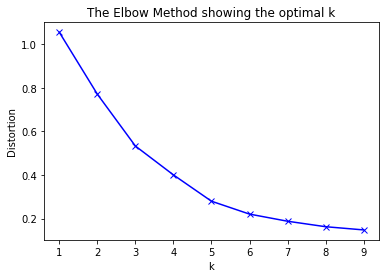

In [86]:


distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_cl)
    kmeanModel.fit(df_cl)
    distortions.append(sum(np.min(cdist(df_cl, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / df_cl.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.title('The Elbow Method showing the optimal k')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

From the Elbow method we conclude that 4 clusters are enough

In [90]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_cl)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:80]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 1, 3, 2, 0, 0,
       0, 0, 2, 3, 3, 0, 2, 3, 3, 0, 3, 2, 3, 0])

Now let's add the cluster labels in our dataframe

In [92]:
df_f.insert(0, 'Cluster Labels', kmeans.labels_)
df_f.head(10)

,Cluster Labels,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
0,0,2,North York,Parkwoods,43.753259,-79.329656,26533.0,5349.0,34811.0,0.0
1,0,3,North York,Victoria Village,43.725882,-79.315572,17047.0,3612.0,29657.0,0.0
3,0,5,North York,Lawrence Heights,43.718518,-79.464763,3769.0,1178.0,29867.0,0.0
4,0,6,North York,Lawrence Manor,43.718518,-79.464763,13750.0,6425.0,36361.0,0.0
7,0,10,Scarborough,Rouge,43.806686,-79.194353,22724.0,791.0,29230.0,0.0
8,0,11,Scarborough,Malvern,43.806686,-79.194353,44324.0,5003.0,25677.0,0.0
13,1,17,Downtown Toronto,Garden District,43.657162,-79.378937,8240.0,15846.0,37614.0,2.0
18,0,24,Etobicoke,Princess Gardens,43.650943,-79.554724,9288.0,2249.0,80607.0,0.0
19,0,25,Etobicoke,West Deane Park,43.650943,-79.554724,4395.0,2063.0,41582.0,0.0
20,0,26,Scarborough,Highland Creek,43.784535,-79.160497,12853.0,2505.0,33640.0,0.0


Now we create the maps that represent the Clusters

The first map illustrates the number of gyms in that neighborhood, while the second illustrates the average income

In [95]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'green', 'blue', 'black']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df_f['Latitude'], df_f['Longitude'], df_f['Neighborhood'], df_f['Cluster Labels'], df_cl[:,1]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*5+15,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [105]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
colours = ['red', 'green', 'blue', 'black']
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, income in zip(df_f['Latitude'], df_f['Longitude'], df_f['Neighborhood'], df_f['Cluster Labels'], df_f['Average Income']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=income*0.00025,
        popup=label,
        #color=rainbow[cluster-1],
        color=colours[cluster],
        fill=True,
        #fill_color=rainbow[cluster-1],
        fill_color=colours[cluster],
        fill_opacity=0.1).add_to(map_clusters)
       
map_clusters

Now we create a scatter plot of out cluster data

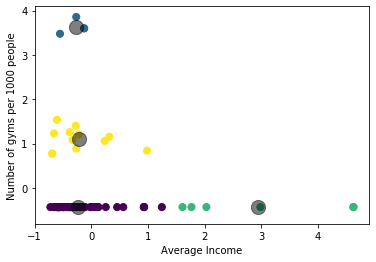

In [108]:

y_kmeans = kmeans.predict(df_cl)
plt.scatter(df_cl[:, 0], df_cl[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.xlabel('Average Income')
plt.ylabel('Number of gyms per 1000 people')
plt.show()

From the scatter plot above we can see there is one cluster with the highest average income while having 0 gyms.

Now let's print each cluster in order to find that cluster

In [109]:
df_f[(df_f['Cluster Labels'] == 0)]

,Cluster Labels,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
0,0,2,North York,Parkwoods,43.753259,-79.329656,26533.0,5349.0,34811.0,0.0
1,0,3,North York,Victoria Village,43.725882,-79.315572,17047.0,3612.0,29657.0,0.0
3,0,5,North York,Lawrence Heights,43.718518,-79.464763,3769.0,1178.0,29867.0,0.0
4,0,6,North York,Lawrence Manor,43.718518,-79.464763,13750.0,6425.0,36361.0,0.0
7,0,10,Scarborough,Rouge,43.806686,-79.194353,22724.0,791.0,29230.0,0.0
8,0,11,Scarborough,Malvern,43.806686,-79.194353,44324.0,5003.0,25677.0,0.0
18,0,24,Etobicoke,Princess Gardens,43.650943,-79.554724,9288.0,2249.0,80607.0,0.0
19,0,25,Etobicoke,West Deane Park,43.650943,-79.554724,4395.0,2063.0,41582.0,0.0
20,0,26,Scarborough,Highland Creek,43.784535,-79.160497,12853.0,2505.0,33640.0,0.0
21,0,27,Scarborough,Rouge Hill,43.784535,-79.160497,11167.0,2878.0,32858.0,0.0


In [110]:
df_f[(df_f['Cluster Labels'] == 1)]

,Cluster Labels,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
13,1,17,Downtown Toronto,Garden District,43.657162,-79.378937,8240.0,15846.0,37614.0,2.0
75,1,100,West Toronto,Brockton,43.636847,-79.428191,9039.0,8217.0,27260.0,2.0
114,1,146,York,Runnymede,43.673185,-79.487262,4382.0,5155.0,42635.0,1.0
144,1,185,West Toronto,Runnymede,43.651571,-79.484450,4382.0,5155.0,42635.0,1.0


In [111]:
df_f[(df_f['Cluster Labels'] == 2)]

,Cluster Labels,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
111,2,143,Central Toronto,Lawrence Park,43.728020,-79.388790,6653.0,1828.0,214110.0,0.0
132,2,170,Central Toronto,Yorkville,43.672710,-79.405678,6045.0,10795.0,105239.0,0.0
149,2,195,Central Toronto,Moore Park,43.689574,-79.383160,4474.0,3959.0,154825.0,0.0
161,2,213,Central Toronto,South Hill,43.686412,-79.400049,6218.0,4935.0,120453.0,0.0
182,2,238,Downtown Toronto,Rosedale,43.679563,-79.377529,7672.0,2821.0,213941.0,0.0
192,2,254,Etobicoke,The Kingsway,43.653654,-79.506944,8780.0,3403.0,110944.0,0.0


In [112]:
df_f[(df_f['Cluster Labels'] == 3)]

,Cluster Labels,index,Borough,Neighborhood,Latitude,Longitude,Population,Population Density,Average Income,Number of Gyms
23,3,30,North York,Flemingdon Park,43.725900,-79.340923,21287.0,8760.0,23471.0,2.0
26,3,33,Downtown Toronto,St. James Town,43.651494,-79.375418,14666.0,63765.0,22341.0,1.0
39,3,55,East York,Leaside,43.709060,-79.363452,13876.0,4938.0,82670.0,1.0
47,3,66,East York,Thorncliffe Park,43.705369,-79.349372,17949.0,5809.0,25340.0,2.0
141,3,182,Central Toronto,Davisville,43.704324,-79.388790,23727.0,7556.0,55735.0,2.0
145,3,186,West Toronto,Swansea,43.651571,-79.484450,11133.0,2961.0,58681.0,1.0
170,3,224,Etobicoke,Humber Bay Shores,43.605647,-79.501321,10775.0,7588.0,39186.0,1.0
172,3,226,Etobicoke,New Toronto,43.605647,-79.501321,10455.0,3858.0,33415.0,1.0
184,3,242,Etobicoke,Alderwood,43.602414,-79.543484,11656.0,2360.0,35239.0,1.0
185,3,243,Etobicoke,Long Branch,43.602414,-79.543484,9625.0,4336.0,37288.0,1.0


<h2>4. Results</h2>

From the above data we can see that Cluster 2 has the 2nd lowest competition while having the highest average income.

<h2>5. Conclusion </h2>

It is obvious that the neighborhoods in the 2nd cluster would be ideal for opening a highly sophisticated and expensive gym and fitness center.